# About the Project: 
Title: Time series regression model for sales prediction for a large retail store

Objective: To develop a predictive model that enhances the accuracy of forecasting store sales for Corporation Favorita, a large grocery retailer headquartered in Ecuador. The model aims to predict the unit sales of numerous items across various Favorita stores, enabling more precise estimation of sales performance.

# Hypothesis and Questions:
Hypothesis: 
The promotional activities, oil prices, and holidays/events have a significant impact on store sales for Corporation Favorita.

Null Hypothesis: The promotional activities, oil prices, and holidays/events do not have a significant impact on store sales for Corporation Favorita.

Alternate Hypothesis: The promotional activities, oil prices, and holidays/events have a significant impact on store sales for Corporation Favorita.

Key Analytical Questions:

1. How does the presence of promotional activities affect store sales?
2. What is the relationship between oil prices and store sales? 
3. Do holidays and events influence store sales? Are there specific holidays/events that drive higher sales?
4. Do sales on holidays significantly differ from sales on regular days?
5. Is there a significant difference in sales by location and by store type?
6. Which store has the highest average sales, and which one has the lowest?
7. Which location has the highest average sales, and which one has the lowest?
8. Which store type has the highest average sales, and which one has the lowest?
9. Did the earthquake impact sales? 
10. Could Supermarket sales could be affected by this?


# Installations and Libraries

In [243]:
# %pip install pyodbc
# %pip install python-dotenv

In [308]:
# Data Handling
import pyodbc
import numpy as np
import pandas as pd
from sklearn.impute import SimpleImputer
from scipy import stats
from dotenv import dotenv_values


# Statistical Analysis
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from scipy.stats import ttest_ind
from sklearn.metrics import mean_absolute_error, mean_squared_error
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA


# Visualization
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.patches as mpatches
import seaborn as sns
import plotly.express as px

# Other Packages
import warnings

warnings.filterwarnings("ignore")

# Data Loading

## SQL Data (Oil, holiday events, stores)

In [245]:
# From SQL Database
# Load environment variables from .env file into a dictionary
environment_variables = dotenv_values('.env')
# Set up the connection string
# Get the values for the credentials 
server = environment_vars.get("SERVER")
database = environment_vars.get("DATABASE")
username = environment_vars.get("USERNAME")
password = environment_vars.get("PASSWORD")
driver = '{ODBC Driver 17 for SQL Server}'
connection_string = f"DRIVER={driver};SERVER={server};DATABASE={database};UID={username};PWD={password}"

# Establish the connection
conn = pyodbc.connect(connection_string)

In [246]:
# Query the first table 'oil' in the database
query1 = 'SELECT * FROM dbo.oil'
oil_df = pd.read_sql(query1, conn)

# Query the second table 'holidays_events' in the database
query2 = 'SELECT * FROM dbo.holidays_events'
holidays_events_df = pd.read_sql(query2, conn)

# Query the third table 'stores' in the database
query3 = 'SELECT * FROM dbo.stores'
stores_df = pd.read_sql(query3, conn)

# Close the cursor and connection
conn.close()

In [247]:
# Display the oil dataframe
oil_df.head()

,date,dcoilwtico
0,2013-01-01,NaN
1,2013-01-02,93.139999
2,2013-01-03,92.970001
3,2013-01-04,93.120003
4,2013-01-07,93.199997


In [248]:
# Display the holiday_events dataframe
holidays_events_df.head()

,date,type,locale,locale_name,description,transferred
0,2012-03-02,Holiday,Local,Manta,Fundacion de Manta,False
1,2012-04-01,Holiday,Regional,Cotopaxi,Provincializacion de Cotopaxi,False
2,2012-04-12,Holiday,Local,Cuenca,Fundacion de Cuenca,False
3,2012-04-14,Holiday,Local,Libertad,Cantonizacion de Libertad,False
4,2012-04-21,Holiday,Local,Riobamba,Cantonizacion de Riobamba,False


In [249]:
# Display the stores dataframe
stores_df.head()

,store_nbr,city,state,type,cluster
0,1,Quito,Pichincha,D,13
1,2,Quito,Pichincha,D,13
2,3,Quito,Pichincha,D,8
3,4,Quito,Pichincha,D,9
4,5,Santo Domingo,Santo Domingo de los Tsachilas,D,4


## Train Dataset

In [250]:
train_df = pd.read_csv("train.csv")
train_df.head()

,id,date,store_nbr,family,sales,onpromotion
0,0,2013-01-01,1,AUTOMOTIVE,0.0,0
1,1,2013-01-01,1,BABY CARE,0.0,0
2,2,2013-01-01,1,BEAUTY,0.0,0
3,3,2013-01-01,1,BEVERAGES,0.0,0
4,4,2013-01-01,1,BOOKS,0.0,0


## Test Dataset

In [251]:
test_df = pd.read_csv("test.csv")
test_df.head()

,id,date,store_nbr,family,onpromotion
0,3000888,2017-08-16,1,AUTOMOTIVE,0
1,3000889,2017-08-16,1,BABY CARE,0
2,3000890,2017-08-16,1,BEAUTY,2
3,3000891,2017-08-16,1,BEVERAGES,20
4,3000892,2017-08-16,1,BOOKS,0


## Transactions Dataset

In [252]:
transactions_df = pd.read_csv('transactions.csv')
transactions_df.head()

,date,store_nbr,transactions
0,2013-01-01,25,770
1,2013-01-02,1,2111
2,2013-01-02,2,2358
3,2013-01-02,3,3487
4,2013-01-02,4,1922


# Exploratory Data Analysis (EDA)

## Understanding the datasets

In [253]:
# Print out the shapes of the train and test datasets
print("Shape of Each Dataset:")
print(f"Train Dataset: {train_df.shape}")
print(f"Test Datasets: {test_df.shape}")
print(f"Holiday Events Dataset: {holidays_events_df.shape}")
print(f"Oil Dataset: {oil_df.shape}")
print(f"Stores Dataset: {stores_df.shape}")
print(f"Transactions Dataset: {transactions_df.shape}")

Shape of Each Dataset:
Train Dataset: (3000888, 6)
Test Datasets: (28512, 5)
Holiday Events Dataset: (350, 6)
Oil Dataset: (1218, 2)
Stores Dataset: (54, 5)
Transactions Dataset: (83488, 3)


In [254]:
# Get the column information of each dataset
# Function to display column information of the datasets
def show_column_info(dataset_name, dataset):
    print(f"Data types for the {dataset_name} dataset:")
    print(dataset.info())
    print('==='*14)

In [255]:
# Column information of the train and test columns
show_column_info('Train', train_df)
print()
show_column_info('Test', test_df)
print()
show_column_info('Holiday events', holidays_events_df)
print()
show_column_info('Oil', oil_df)
print()
show_column_info('Stores', stores_df)
print()
show_column_info('Transactions', transactions_df)

Data types for the Train dataset:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000888 entries, 0 to 3000887
Data columns (total 6 columns):
 #   Column       Dtype  
---  ------       -----  
 0   id           int64  
 1   date         object 
 2   store_nbr    int64  
 3   family       object 
 4   sales        float64
 5   onpromotion  int64  
dtypes: float64(1), int64(3), object(2)
memory usage: 137.4+ MB
None

Data types for the Test dataset:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28512 entries, 0 to 28511
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   id           28512 non-null  int64 
 1   date         28512 non-null  object
 2   store_nbr    28512 non-null  int64 
 3   family       28512 non-null  object
 4   onpromotion  28512 non-null  int64 
dtypes: int64(3), object(2)
memory usage: 1.1+ MB
None

Data types for the Holiday events dataset:
<class 'pandas.core.frame.DataFrame'>
RangeIndex:

In [256]:
# Converting the 'date' column in the datasets to datetime format
# Train dataset
train_df['date'] = pd.to_datetime(train_df['date'])

# Test dataset
test_df['date'] = pd.to_datetime(test_df['date'])

# Holiday Events dataset
holidays_events_df['date'] = pd.to_datetime(holidays_events_df['date'])

# Oil dataset
oil_df['date'] = pd.to_datetime(oil_df['date'])

# Transactions dataset
transactions_df['date'] = pd.to_datetime(transactions_df['date'])

In [257]:
# Checking for the summary statistics of the datasets 
datasets = {'train': train_df, 'test': test_df, 'holiday events': holidays_events_df, 'oil': oil_df, 'stores': stores_df, 'transactions': transactions_df}

for name, data in datasets.items():
    print(f"{name.capitalize()} dataset summary statistics:")
    print('---'*15)
    print(data.describe())
    print('==='*20)
    print()

Train dataset summary statistics:
---------------------------------------------


                 id     store_nbr         sales   onpromotion
count  3.000888e+06  3.000888e+06  3.000888e+06  3.000888e+06
mean   1.500444e+06  2.750000e+01  3.577757e+02  2.602770e+00
std    8.662819e+05  1.558579e+01  1.101998e+03  1.221888e+01
min    0.000000e+00  1.000000e+00  0.000000e+00  0.000000e+00
25%    7.502218e+05  1.400000e+01  0.000000e+00  0.000000e+00
50%    1.500444e+06  2.750000e+01  1.100000e+01  0.000000e+00
75%    2.250665e+06  4.100000e+01  1.958473e+02  0.000000e+00
max    3.000887e+06  5.400000e+01  1.247170e+05  7.410000e+02

Test dataset summary statistics:
---------------------------------------------
                 id     store_nbr   onpromotion
count  2.851200e+04  28512.000000  28512.000000
mean   3.015144e+06     27.500000      6.965383
std    8.230850e+03     15.586057     20.683952
min    3.000888e+06      1.000000      0.000000
25%    3.008016e+06     14.000000      0.000000
50%    3.015144e+06     27.500000      0.000000
75%    3.022271e+06     41

## Checking for missing values

In [258]:
# Check for missing values in the datasets
datasets = {'train': train_df, 'test': test_df, 'holiday events': holidays_events_df, 'oil': oil_df, 'stores': stores_df, 'transactions': transactions_df, }

def show_missing_values(datasets):
    for name, data in datasets.items():
        print(f"Missing values in the {name.capitalize()} dataset:")
        print(data.isnull().sum())
        print('===' * 18)
        print()

show_missing_values(datasets)

Missing values in the Train dataset:
id             0
date           0
store_nbr      0
family         0
sales          0
onpromotion    0
dtype: int64

Missing values in the Test dataset:
id             0
date           0
store_nbr      0
family         0
onpromotion    0
dtype: int64

Missing values in the Holiday events dataset:
date           0
type           0
locale         0
locale_name    0
description    0
transferred    0
dtype: int64

Missing values in the Oil dataset:
date           0
dcoilwtico    43
dtype: int64

Missing values in the Stores dataset:
store_nbr    0
city         0
state        0
type         0
cluster      0
dtype: int64

Missing values in the Transactions dataset:
date            0
store_nbr       0
transactions    0
dtype: int64



## Handling missing values

In [259]:
# Fill missing values in the 'dcoilwtico' column using backfill strategy
oil_df['dcoilwtico'] = oil_df['dcoilwtico'].fillna(method='backfill')

In [260]:
# Check for missing values after handling
missing_values_after = oil_df['dcoilwtico'].isnull().sum()
missing_values_after

0

## Checking completeness of train dataset

In [261]:
# Check the completeness of the train dataset
min_date = train_df['date'].min()
max_date = train_df['date'].max()
expected_dates = pd.date_range(start=min_date, end=max_date)

missing_dates = expected_dates[~expected_dates.isin(train_df['date'])]

if len(missing_dates) == 0:
    print("The train dataset is complete. It includes all the required dates.")
else:
    print("The train dataset is incomplete. The following dates are missing:")
    print(missing_dates)

The train dataset is incomplete. The following dates are missing:
DatetimeIndex(['2013-12-25', '2014-12-25', '2015-12-25', '2016-12-25'], dtype='datetime64[ns]', freq=None)


In [262]:
# Complete the missing dates in the train dataset
# Create an index of the missing dates as a DatetimeIndex object
missing_dates = pd.Index(['2013-12-25', '2014-12-25', '2015-12-25', '2016-12-25'], dtype='datetime64[ns]')

# Create a DataFrame with the missing dates, using the 'date' column
missing_data = pd.DataFrame({'date': missing_dates})

# Concatenate the original train dataset and the missing data DataFrame
# ignore_index=True ensures a new index is assigned to the resulting DataFrame
train_df = pd.concat([train_df, missing_data], ignore_index=True)

# Sort the DataFrame based on the 'date' column in ascending order
train_df.sort_values('date', inplace=True)

In [263]:
# Check the completeness of the train dataset
min_date = train_df['date'].min()
max_date = train_df['date'].max()
expected_dates = pd.date_range(start=min_date, end=max_date)

missing_dates = expected_dates[~expected_dates.isin(train_df['date'])]

if len(missing_dates) == 0:
    print("The train dataset is complete. It includes all the required dates.")
else:
    print("The train dataset is incomplete. The following dates are missing:")
    print(missing_dates)

The train dataset is complete. It includes all the required dates.


## Merging Datasets

In [264]:
# Merging on the common columns ('store_nbr' and 'date') in the datasets using the inner merge() function
# Merge train_df with stores_df on 'store_nbr' column
merged_df1 = train_df.merge(stores_df, on='store_nbr', how='inner')

# Merge merged_df1 with transactions_df on 'date' and 'store_nbr' columns
merged_df2 = merged_df1.merge(transactions_df, on=['date', 'store_nbr'], how='inner')

# Merge merged_df2 with holidays_events_df on 'date' column
merged_df3 = merged_df2.merge(holidays_events_df, on='date', how='inner')

# Merge merged_df3 with oil_df on 'date' column
merged_df = merged_df3.merge(oil_df, on='date', how='inner')

# View the first five rows of the merged dataset
merged_df.head()

,id,date,store_nbr,family,sales,onpromotion,city,state,type_x,cluster,transactions,type_y,locale,locale_name,description,transferred,dcoilwtico
0,73062.0,2013-02-11,1.0,AUTOMOTIVE,0.0,0.0,Quito,Pichincha,D,13,396,Holiday,National,Ecuador,Carnaval,False,97.010002
1,73085.0,2013-02-11,1.0,MAGAZINES,0.0,0.0,Quito,Pichincha,D,13,396,Holiday,National,Ecuador,Carnaval,False,97.010002
2,73084.0,2013-02-11,1.0,"LIQUOR,WINE,BEER",21.0,0.0,Quito,Pichincha,D,13,396,Holiday,National,Ecuador,Carnaval,False,97.010002
3,73083.0,2013-02-11,1.0,LINGERIE,0.0,0.0,Quito,Pichincha,D,13,396,Holiday,National,Ecuador,Carnaval,False,97.010002
4,73082.0,2013-02-11,1.0,LAWN AND GARDEN,3.0,0.0,Quito,Pichincha,D,13,396,Holiday,National,Ecuador,Carnaval,False,97.010002


In [265]:
# Check the column information of the merged dataset
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 322047 entries, 0 to 322046
Data columns (total 17 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   id            322047 non-null  float64       
 1   date          322047 non-null  datetime64[ns]
 2   store_nbr     322047 non-null  float64       
 3   family        322047 non-null  object        
 4   sales         322047 non-null  float64       
 5   onpromotion   322047 non-null  float64       
 6   city          322047 non-null  object        
 7   state         322047 non-null  object        
 8   type_x        322047 non-null  object        
 9   cluster       322047 non-null  int64         
 10  transactions  322047 non-null  int64         
 11  type_y        322047 non-null  object        
 12  locale        322047 non-null  object        
 13  locale_name   322047 non-null  object        
 14  description   322047 non-null  object        
 15  transferred   322

In [266]:
# Check the unique values of the two unknown columns
print("Unique values of 'type_x':")
print(merged_df['type_x'].unique())
print()
print("Unique values of 'type_y':")
print(merged_df['type_y'].unique())

Unique values of 'type_x':
['D' 'E' 'C' 'A' 'B']

Unique values of 'type_y':
['Holiday' 'Additional' 'Transfer' 'Event' 'Bridge']


In [267]:
# Renaming the columns with the approapriate names
merged_df = merged_df.rename(columns={"type_x": "store_type", "type_y": "holiday_type"})
merged_df.head()

,id,date,store_nbr,family,sales,onpromotion,city,state,store_type,cluster,transactions,holiday_type,locale,locale_name,description,transferred,dcoilwtico
0,73062.0,2013-02-11,1.0,AUTOMOTIVE,0.0,0.0,Quito,Pichincha,D,13,396,Holiday,National,Ecuador,Carnaval,False,97.010002
1,73085.0,2013-02-11,1.0,MAGAZINES,0.0,0.0,Quito,Pichincha,D,13,396,Holiday,National,Ecuador,Carnaval,False,97.010002
2,73084.0,2013-02-11,1.0,"LIQUOR,WINE,BEER",21.0,0.0,Quito,Pichincha,D,13,396,Holiday,National,Ecuador,Carnaval,False,97.010002
3,73083.0,2013-02-11,1.0,LINGERIE,0.0,0.0,Quito,Pichincha,D,13,396,Holiday,National,Ecuador,Carnaval,False,97.010002
4,73082.0,2013-02-11,1.0,LAWN AND GARDEN,3.0,0.0,Quito,Pichincha,D,13,396,Holiday,National,Ecuador,Carnaval,False,97.010002


In [268]:
# Check the column information of the merged dataset again
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 322047 entries, 0 to 322046
Data columns (total 17 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   id            322047 non-null  float64       
 1   date          322047 non-null  datetime64[ns]
 2   store_nbr     322047 non-null  float64       
 3   family        322047 non-null  object        
 4   sales         322047 non-null  float64       
 5   onpromotion   322047 non-null  float64       
 6   city          322047 non-null  object        
 7   state         322047 non-null  object        
 8   store_type    322047 non-null  object        
 9   cluster       322047 non-null  int64         
 10  transactions  322047 non-null  int64         
 11  holiday_type  322047 non-null  object        
 12  locale        322047 non-null  object        
 13  locale_name   322047 non-null  object        
 14  description   322047 non-null  object        
 15  transferred   322

In [269]:
# Generate summary statistics and transpose the rows and columns of the resultant DataFrame.
# Transposing flips the DataFrame (the rows become columns and the columns become rows) for better readability
merged_df.describe().T

,count,mean,std,min,25%,50%,75%,max
id,322047.0,1.682979e+06,786249.257767,561.000000,1.010616e+06,1842406.00,2.209556e+06,3.000887e+06
store_nbr,322047.0,2.699467e+01,15.595174,1.000000,1.300000e+01,27.00,4.000000e+01,5.400000e+01
sales,322047.0,4.063835e+02,1246.881240,0.000000,1.000000e+00,19.00,2.412605e+02,1.247170e+05
onpromotion,322047.0,3.727136e+00,15.512095,0.000000,0.000000e+00,0.00,1.000000e+00,7.160000e+02
cluster,322047.0,8.531202e+00,4.713809,1.000000,4.000000e+00,9.00,1.300000e+01,1.700000e+01
transactions,322047.0,1.734118e+03,1050.335018,54.000000,1.030000e+03,1409.00,2.148000e+03,8.359000e+03
dcoilwtico,322047.0,6.363638e+01,24.855753,27.959999,4.488000e+01,51.98,9.409000e+01,1.079500e+02


In [270]:
# Check for missing values in the merged datasets
missing_values = merged_df.isnull().sum()
missing_values

id              0
date            0
store_nbr       0
family          0
sales           0
onpromotion     0
city            0
state           0
store_type      0
cluster         0
transactions    0
holiday_type    0
locale          0
locale_name     0
description     0
transferred     0
dcoilwtico      0
dtype: int64

In [271]:
# Check for duplicate values in the merged dataset
duplicate_rows_merged = merged_df.duplicated()
duplicate_rows_merged.sum()

0

In [272]:
# Check for duplicate values in the test dataset
duplicate_rows_test = test_df.duplicated()
duplicate_rows_test.sum()

0

In [273]:
# Save merged dataset in csv file for further analysis in PowerBI
merged_df.to_csv('FavoritaStores_Data.csv', index=False)
merged_df.head()

,id,date,store_nbr,family,sales,onpromotion,city,state,store_type,cluster,transactions,holiday_type,locale,locale_name,description,transferred,dcoilwtico
0,73062.0,2013-02-11,1.0,AUTOMOTIVE,0.0,0.0,Quito,Pichincha,D,13,396,Holiday,National,Ecuador,Carnaval,False,97.010002
1,73085.0,2013-02-11,1.0,MAGAZINES,0.0,0.0,Quito,Pichincha,D,13,396,Holiday,National,Ecuador,Carnaval,False,97.010002
2,73084.0,2013-02-11,1.0,"LIQUOR,WINE,BEER",21.0,0.0,Quito,Pichincha,D,13,396,Holiday,National,Ecuador,Carnaval,False,97.010002
3,73083.0,2013-02-11,1.0,LINGERIE,0.0,0.0,Quito,Pichincha,D,13,396,Holiday,National,Ecuador,Carnaval,False,97.010002
4,73082.0,2013-02-11,1.0,LAWN AND GARDEN,3.0,0.0,Quito,Pichincha,D,13,396,Holiday,National,Ecuador,Carnaval,False,97.010002


In [274]:
# Create A Copy of The Merged Dataset
merged_df_copy = merged_df.copy()

## Variate Analyses

### Univariate Analyses

#### Distribution of "sales" variable

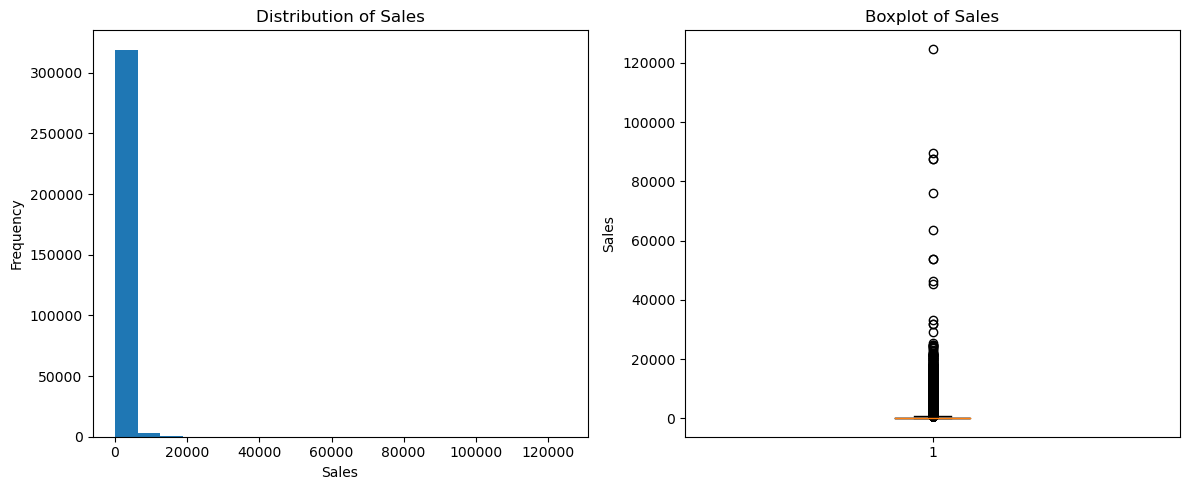

In [275]:
# Create a figure and two subplots side by side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Plot the histogram on the first subplot (ax1)
ax1.hist(merged_df['sales'], bins=20)
ax1.set_xlabel('Sales')
ax1.set_ylabel('Frequency')
ax1.set_title('Distribution of Sales')

# Plot the boxplot on the second subplot (ax2)
ax2.boxplot(merged_df['sales'])
ax2.set_ylabel('Sales')
ax2.set_title('Boxplot of Sales')

# Adjust layout to avoid overlapping labels
plt.tight_layout()

# Show the plots
plt.show()

#### Distribution of "transactions" variable

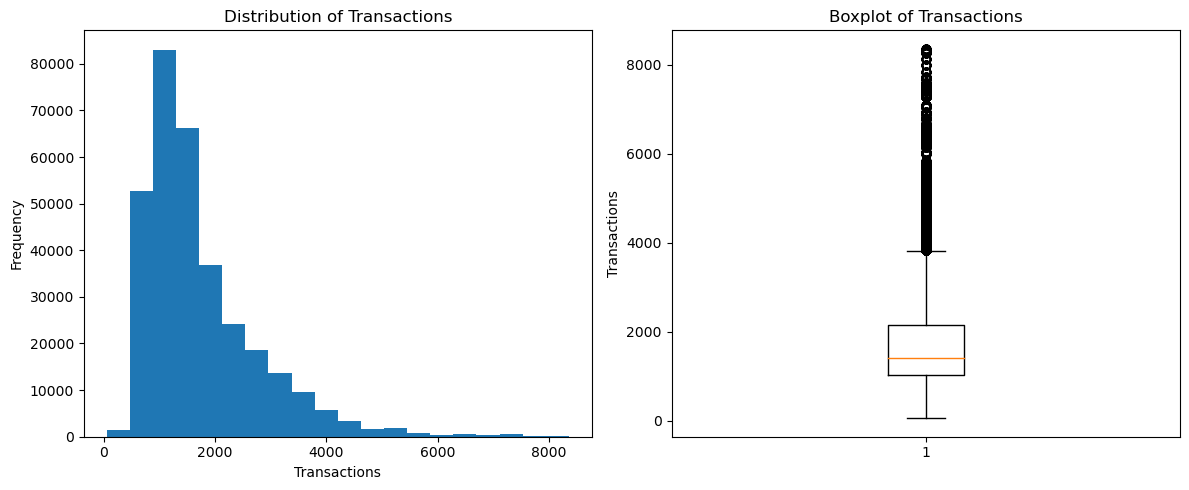

In [276]:
# Create a figure and two subplots side by side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Plot the histogram on the first subplot (ax1)
ax1.hist(merged_df['transactions'], bins=20)
ax1.set_xlabel('Transactions')
ax1.set_ylabel('Frequency')
ax1.set_title('Distribution of Transactions')

# Plot the boxplot on the second subplot (ax2)
ax2.boxplot(merged_df['transactions'])
ax2.set_ylabel('Transactions')
ax2.set_title('Boxplot of Transactions')

# Adjust layout to avoid overlapping labels
plt.tight_layout()

# Show the plots
plt.show()

#### Distribution of oil price variable

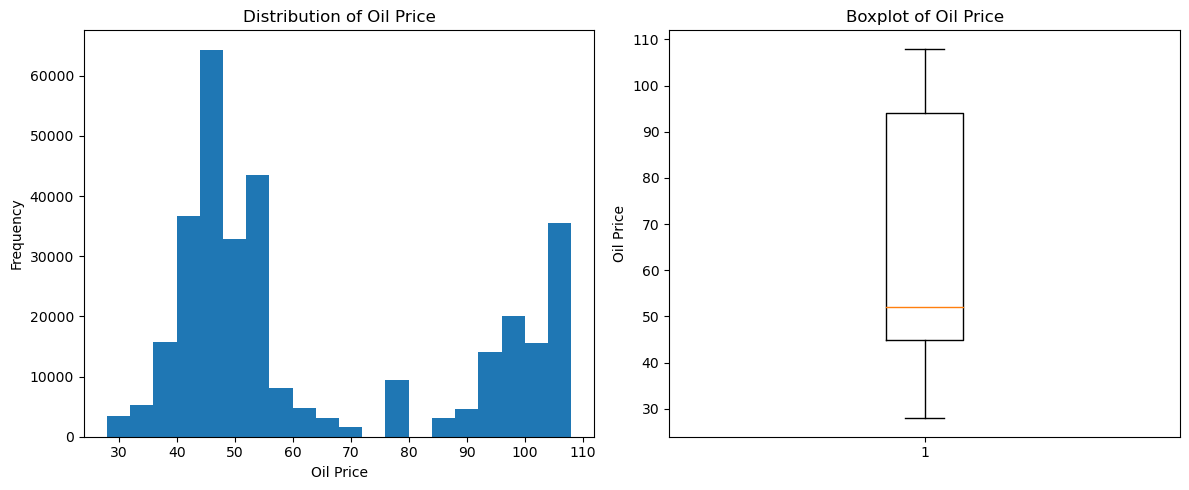

In [277]:
# Create a figure and two subplots side by side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Plot the histogram on the first subplot (ax1)
ax1.hist(merged_df['dcoilwtico'], bins=20)
ax1.set_xlabel('Oil Price')
ax1.set_ylabel('Frequency')
ax1.set_title('Distribution of Oil Price')

# Plot the boxplot on the second subplot (ax2)
ax2.boxplot(merged_df['dcoilwtico'])
ax2.set_ylabel('Oil Price')
ax2.set_title('Boxplot of Oil Price')

# Adjust layout to avoid overlapping labels
plt.tight_layout()

# Show the plots
plt.show()

### Bivariate Analyses

#### Trend of sales 

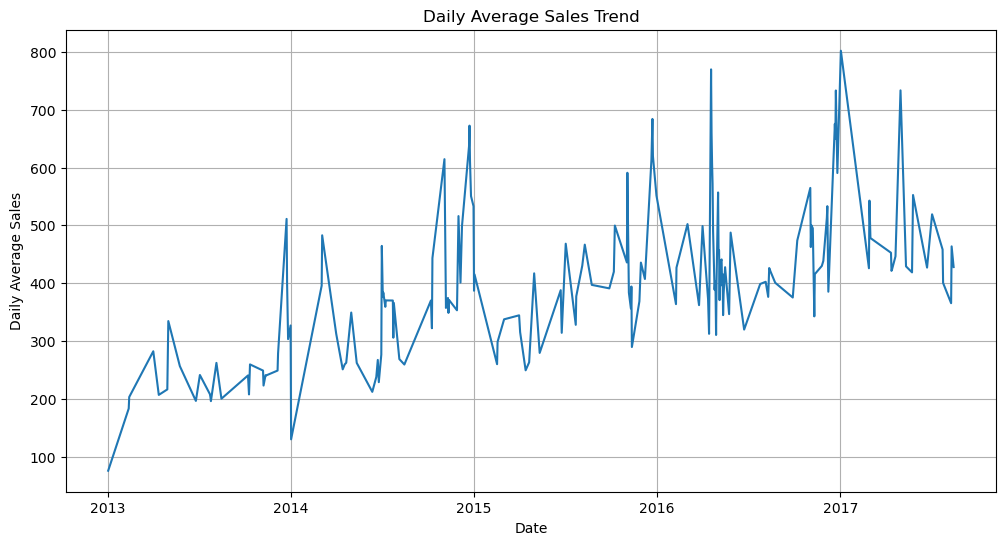

In [323]:
# Convert 'date' column to datetime format (if not already done)
merged_df['date'] = pd.to_datetime(merged_df['date'])

# Group the data by date and calculate the daily average sales
daily_avg_sales = merged_df.groupby('date')['sales'].mean()

# Plot the daily average sales trend
plt.figure(figsize=(12, 6))
plt.plot(daily_avg_sales.index, daily_avg_sales.values)
plt.xlabel('Date')
plt.ylabel('Daily Average Sales')
plt.title('Daily Average Sales Trend')
plt.grid(True)
plt.show()

In [278]:
# Group the data by date and calculate the total sales
daily_sales = merged_df.groupby('date')['sales'].sum().reset_index()

# Create a time series plot with slider
fig = px.line(daily_sales, x='date', y='sales')
fig.update_xaxes(rangeslider_visible=True)
fig.update_layout(title='Trend of Sales Over Time', title_x=0.5)
fig.show()

## Trend in different time frames (Annually, Quarterly, Monthly, and Weekly)

### Annual trend

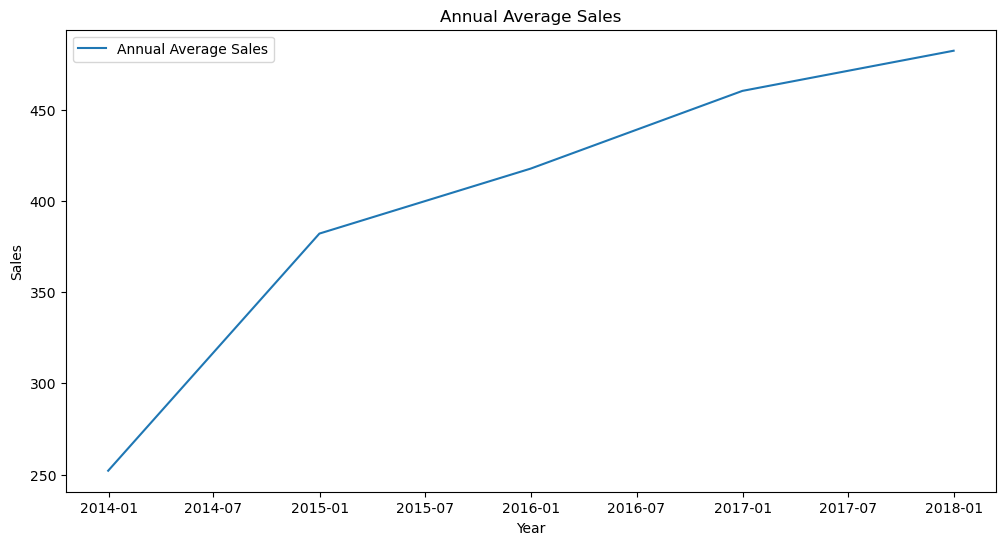

In [318]:
# Convert 'date' column to datetime format 
merged_df['date'] = pd.to_datetime(merged_df['date'])

# Calculate annual average sales
annual_sales = merged_df.resample('Y', on='date')['sales'].mean()

# Plot annual average sales
plt.figure(figsize=(12, 6))
plt.plot(annual_sales.index, annual_sales.values, label='Annual Average Sales')
plt.xlabel('Year')
plt.ylabel('Sales')
plt.title('Annual Average Sales')
plt.legend()
plt.show()


### Quarterly

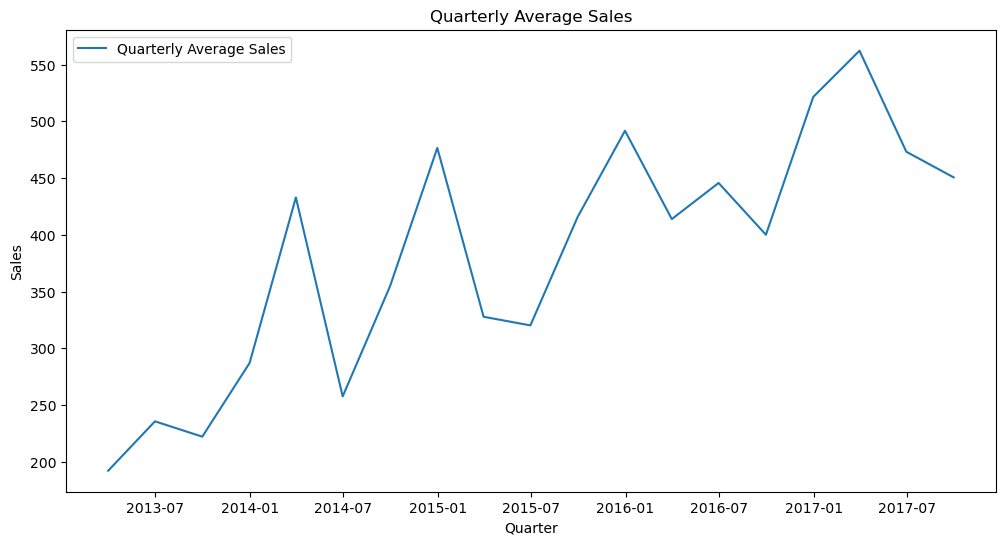

In [319]:
# Convert 'date' column to datetime format 
merged_df['date'] = pd.to_datetime(merged_df['date'])

# Calculate quarterly average sales
quarterly_sales = merged_df.resample('Q', on='date')['sales'].mean()

# Plot quarterly average sales
plt.figure(figsize=(12, 6))
plt.plot(quarterly_sales.index, quarterly_sales.values, label='Quarterly Average Sales')
plt.xlabel('Quarter')
plt.ylabel('Sales')
plt.title('Quarterly Average Sales')
plt.legend()
plt.show()

### Monthly Trend

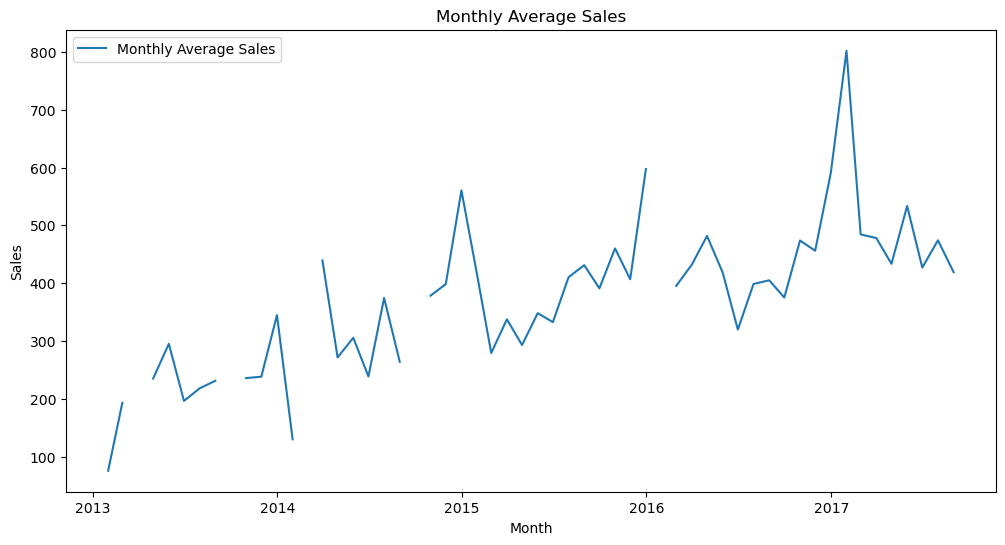

In [320]:
# Convert 'date' column to datetime format 
merged_df['date'] = pd.to_datetime(merged_df['date'])

# Calculate monthly average sales
monthly_sales = merged_df.resample('M', on='date')['sales'].mean()

# Plot monthly average sales
plt.figure(figsize=(12, 6))
plt.plot(monthly_sales.index, monthly_sales.values, label='Monthly Average Sales')
plt.xlabel('Month')
plt.ylabel('Sales')
plt.title('Monthly Average Sales')
plt.legend()
plt.show()

### Weekly Trend

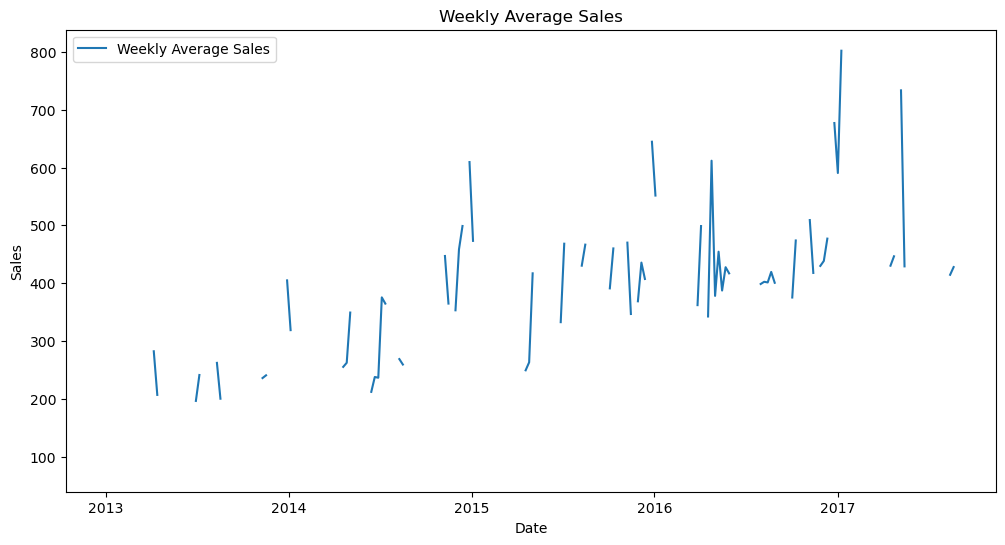

In [321]:
# Convert 'date' column to datetime format 
merged_df['date'] = pd.to_datetime(merged_df['date'])

# Calculate weekly average sales
weekly_sales = merged_df.resample('W', on='date')['sales'].mean()

# Plot weekly average sales
plt.figure(figsize=(12, 6))
plt.plot(weekly_sales.index, weekly_sales.values, label='Weekly Average Sales')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.title('Weekly Average Sales')
plt.legend()
plt.show()

#### Trend of crude oil prices

In [279]:
# Visualizing the 'dcoilwtico' column to confirm if the trend is consistent.
fig = px.line(oil_df, x='date', y='dcoilwtico')
fig.update_layout(title='Trend of Oil Prices Over Time', title_x=0.5, xaxis_title='Date', yaxis_title='Oil Price')
fig.show()

#### Count of sales by store type

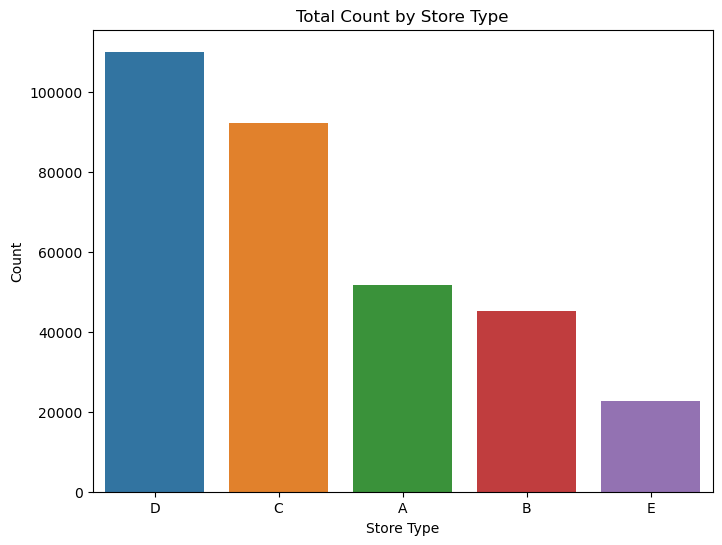

In [280]:
# Calculate the total count and total sales per store type
store_type_counts = merged_df['store_type'].value_counts()
store_type_sales = merged_df.groupby('store_type')['sales'].sum()

# Create a bar plot with "viridis" color palette for total count
plt.figure(figsize=(8, 6))
sns.barplot(x=store_type_counts.index, y=store_type_counts.values)
plt.xlabel('Store Type')
plt.ylabel('Count')
plt.title('Total Count by Store Type')
plt.show()

#### Amount of sales by storetype

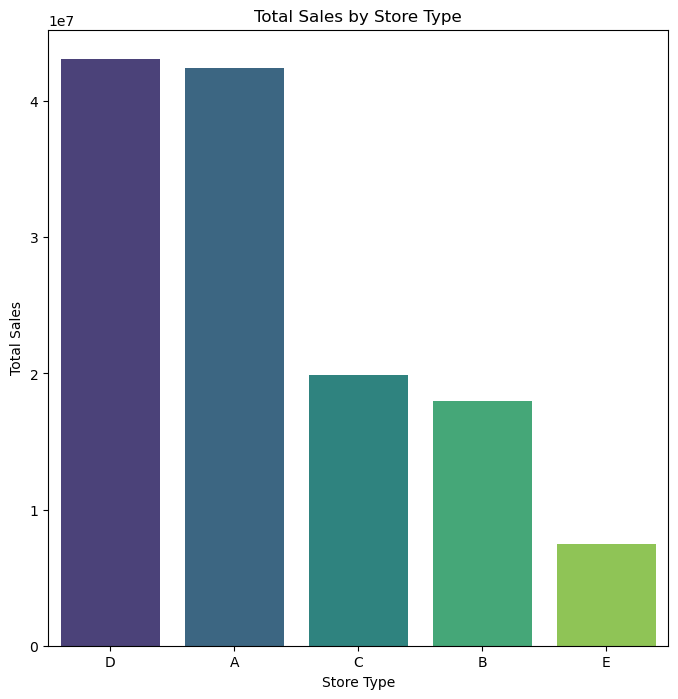

In [281]:
# Order the store types by total sales
store_type_sales = store_type_sales.sort_values(ascending=False)

# Create a bar plot with "viridis" color palette for total sales
plt.figure(figsize=(8, 8))
sns.barplot(x=store_type_sales.index, y=store_type_sales.values, order=store_type_sales.index, palette="viridis")
plt.xlabel('Store Type')
plt.ylabel('Total Sales')
plt.title('Total Sales by Store Type')
plt.show()

#### Average sales by city

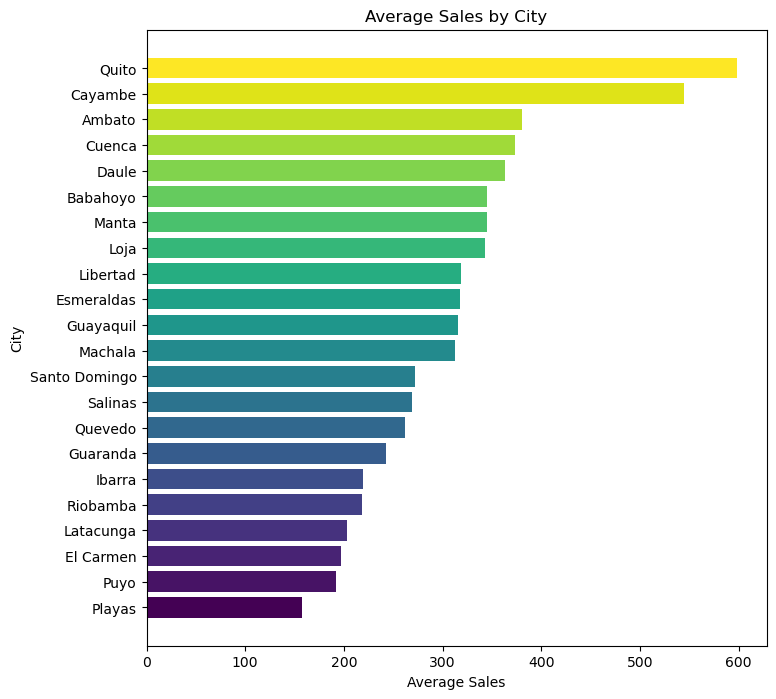

In [282]:
# Group by city and calculate the average sales
average_sales_by_city = merged_df.groupby('city')['sales'].mean()

# Sort the data by average sales in ascending order
average_sales_by_city = average_sales_by_city.sort_values(ascending=True)

# Define colors for the bar plot using 'viridis' color palette
colors = cm.viridis(np.linspace(0, 1, len(average_sales_by_city)))

# Plot the average sales by city horizontally
plt.figure(figsize=(8, 8))
plt.barh(average_sales_by_city.index, average_sales_by_city.values, color=colors)
plt.xlabel('Average Sales')
plt.ylabel('City')
plt.title('Average Sales by City')
plt.show()

#### Average sales by state

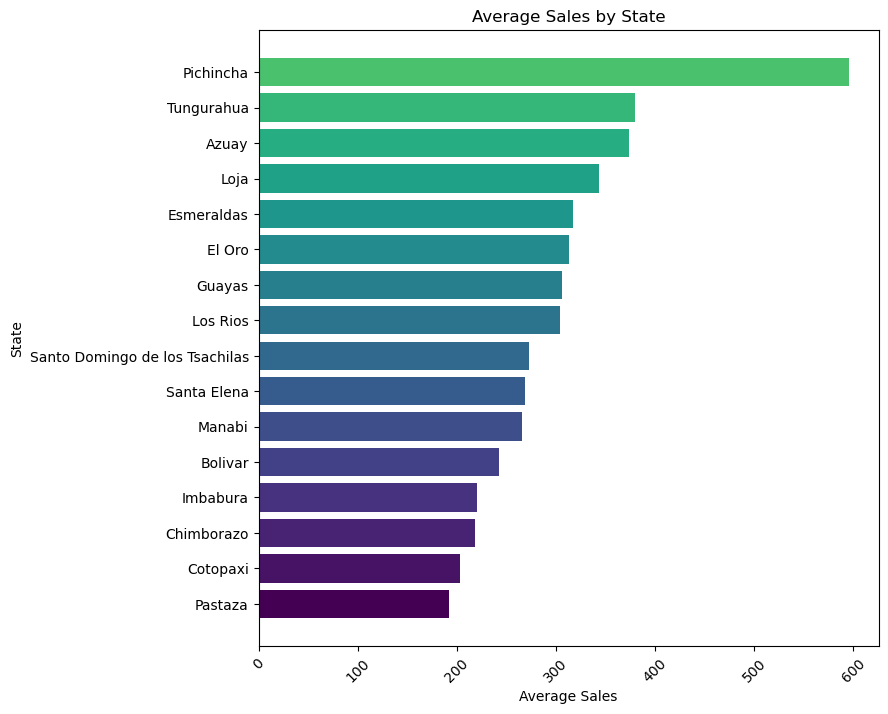

In [283]:
# Group by state and calculate the average sales
average_sales_by_state = merged_df.groupby('state')['sales'].mean()

# Sort the data by average sales in descending order
average_sales_by_state = average_sales_by_state.sort_values(ascending=True)

# Plot the average sales by state
plt.figure(figsize=(8, 8))
plt.barh(average_sales_by_state.index, average_sales_by_state.values, color=colors)
plt.xlabel('Average Sales')
plt.ylabel('State')
plt.title('Average Sales by State')
plt.xticks(rotation=45)
plt.show()

#### Relationship between sales and transactions

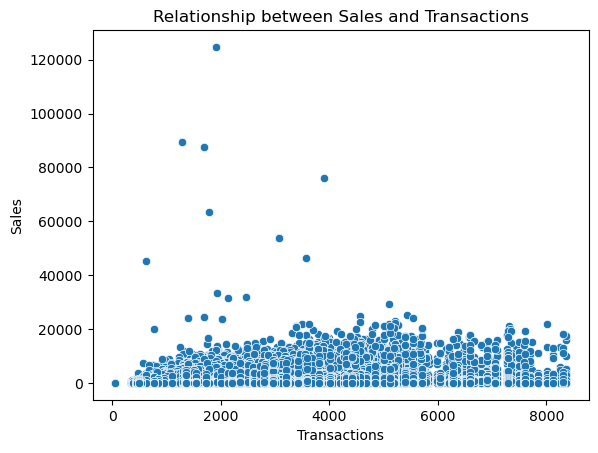

In [284]:
sns.scatterplot(x='transactions', y='sales', data=merged_df)
plt.xlabel('Transactions')
plt.ylabel('Sales')
plt.title('Relationship between Sales and Transactions')
plt.show()

### Multivariate Analyses

#### Correlation Matrix of numerical variable

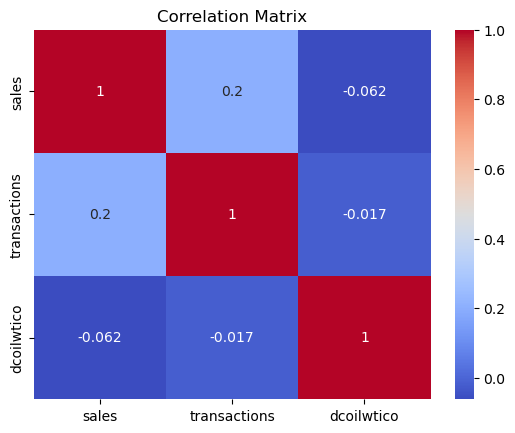

In [285]:
# Select numerical variables for correlation analysis
numerical_vars = ['sales', 'transactions', 'dcoilwtico']

# Compute correlation matrix
corr_matrix = merged_df[numerical_vars].corr()

# Plot heatmap
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

#### Scatter plot of numerical variables

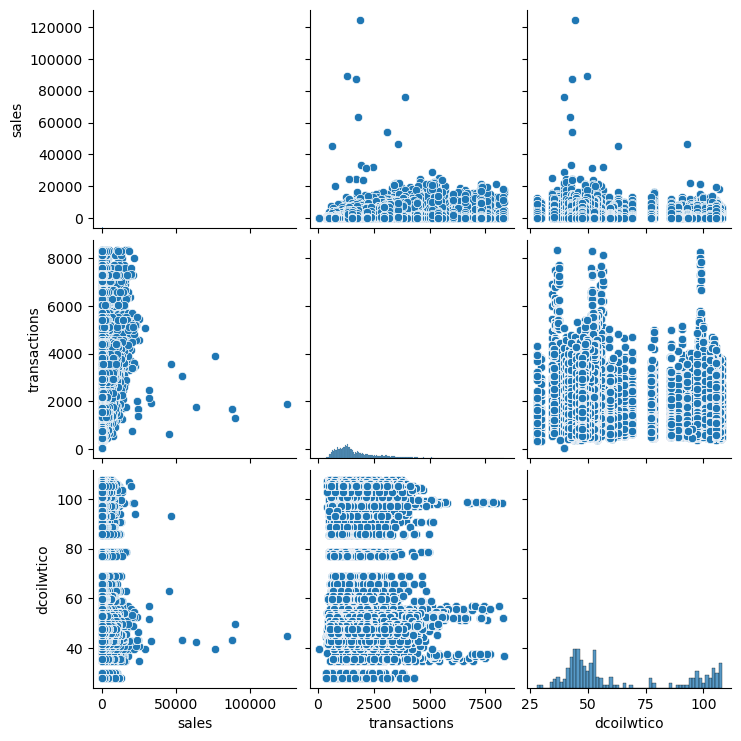

In [286]:
# Select numerical variables for correlation analysis
numerical_vars = ['sales', 'transactions', 'dcoilwtico']

# Plot scatter plot matrix
sns.pairplot(merged_df[numerical_vars])
plt.show()

# Test of Hypotheses and Answering Key Questions

Hypothesis: 
The promotional activities, oil prices, and holidays/events have a significant impact on store sales for Corporation Favorita.

Null Hypothesis: The promotional activities, oil prices, and holidays/events do not have a significant impact on store sales for Corporation Favorita.

Alternate Hypothesis: The promotional activities, oil prices, and holidays/events have a significant impact on store sales for Corporation Favorita.


##### Test for promotional activities

In [287]:
# Prepare the independent variable (promotional activities)
onpromotion = merged_df['onpromotion']

# Prepare the dependent variable (store sales)
sales = merged_df['sales']

# Perform the t-test for promotional activities on store sales
t_stat, p_value = stats.ttest_ind(sales[onpromotion == 1], sales[onpromotion == 0], equal_var=False)

# Print the p-value
print("P-value:", p_value)

# Check the p-value to determine the significance
alpha = 0.05
if p_value < alpha:
    print("Promotional activities have a significant impact on store sales.")
else:
    print("Promotional activities do not have a significant impact on store sales.")

P-value: 0.0
Promotional activities have a significant impact on store sales.


##### Test for Oil prices

In [288]:
# Prepare the independent variable (oil prices)
dcoilwtico = merged_df['dcoilwtico']

# Perform the t-test for oil prices on store sales
t_stat, p_value = stats.ttest_ind(sales[dcoilwtico > 0], sales[dcoilwtico <= 0], equal_var=False)

# Print the p-value
print("P-value:", p_value)

# Check the p-value to determine the significance
alpha = 0.05
if p_value < alpha:
    print("Oil prices have a significant impact on store sales.")
else:
    print("Oil prices do not have a significant impact on store sales.")


P-value: nan
Oil prices do not have a significant impact on store sales.


##### Test for Holidays/Events

In [289]:
# Prepare the independent variable (holidays/events)
holiday_type = merged_df['holiday_type']

# Perform the t-test for holidays/events on store sales
holiday_sales = sales[holiday_type != 'None']
non_holiday_sales = sales[holiday_type == 'None']
t_stat, p_value = stats.ttest_ind(holiday_sales, non_holiday_sales, equal_var=False)

# Print the p-value
print("P-value:", p_value)

# Check the p-value to determine the significance
alpha = 0.05
if p_value < alpha:
    print("Holidays/Events have a significant impact on store sales.")
else:
    print("Holidays/Events do not have a significant impact on store sales.")

P-value: nan
Holidays/Events do not have a significant impact on store sales.


Key Analytical Questions:

1. How does the presence of promotional activities affect store sales?
2. What is the relationship between oil prices and store sales? 
3. Do holidays and events influence store sales? Are there specific holidays/events that drive higher sales?
4. Do sales on holidays significantly differ from sales on regular days?
5. Is there a significant difference in sales by location and by store type?
6. Which store has the highest average sales, and which one has the lowest?
7. Which location has the highest average sales, and which one has the lowest?
8. Which store type has the highest average sales, and which one has the lowest?
9. Did the earthquake impact sales? 
10. Could Supermarket sales could be affected by this?

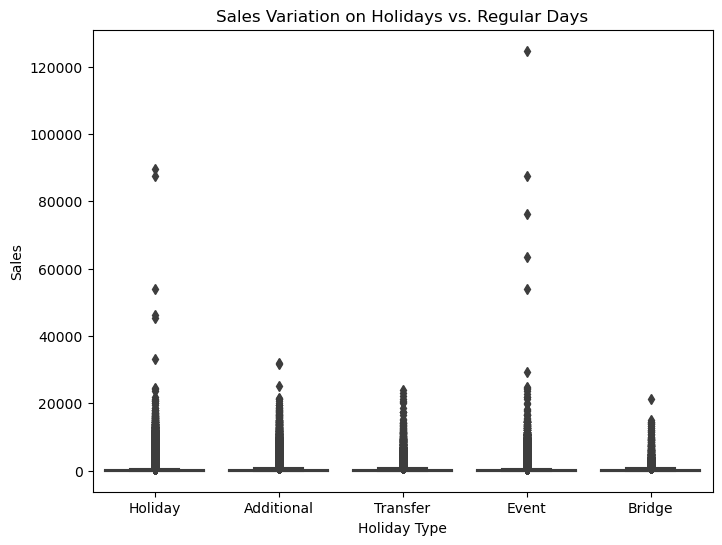

P-value: nan
nan
There is no significant difference in sales between holidays and regular days.


In [290]:
# Question 4. Do sales on holidays significantly differ from sales on regular days?

# Box plot to visualize sales variation on holidays and regular days
plt.figure(figsize=(8, 6))
sns.boxplot(x='holiday_type', y='sales', data=merged_df)
plt.xlabel('Holiday Type')
plt.ylabel('Sales')
plt.title('Sales Variation on Holidays vs. Regular Days')
plt.show()

# Check significance in difference
# Separate sales data for holidays and regular days
sales_on_holidays = merged_df[merged_df['holiday_type'] == 'Holiday']['sales']
sales_on_regular_days = merged_df[merged_df['holiday_type'] == 'Regular']['sales']

# Perform two-sample t-test
t_stat, p_value = stats.ttest_ind(sales_on_holidays, sales_on_regular_days, equal_var=False)

# Print the p-value
print("P-value:", p_value)

# Define significance level
alpha = 0.05

# Check the p-value to determine significance
if p_value < alpha:
    print("There is a significant difference in sales between holidays and regular days.")
else:
    print("There is no significant difference in sales between holidays and regular days.")

In [291]:
# Question 5: Is there a significant difference in sales by location and by store type?

import statsmodels.api as sm
from statsmodels.formula.api import ols

# Perform ANOVA for sales by location
anova_location = ols('sales ~ C(city)', data=merged_df).fit()
anova_table_location = sm.stats.anova_lm(anova_location, typ=2)

# Perform ANOVA for sales by store type
anova_store_type = ols('sales ~ C(store_type)', data=merged_df).fit()
anova_table_store_type = sm.stats.anova_lm(anova_store_type, typ=2)

# Print the p-value
print("P-value:", p_value)

# Define significance level
alpha = 0.05

# Check if there is a significant difference in sales by location
if anova_table_location['PR(>F)'][0] < alpha:
    print("There is a significant difference in sales by location.")
else:
    print("There is no significant difference in sales by location.")

# Check if there is a significant difference in sales by store type
if anova_table_store_type['PR(>F)'][0] < alpha:
    print("There is a significant difference in sales by store type.")
else:
    print("There is no significant difference in sales by store type.")

P-value: nan
There is a significant difference in sales by location.
There is a significant difference in sales by store type.


In [292]:
# Question 6: Which store has the highest average sales, and which one has the lowest?

# Calculate average sales for each store
average_sales_by_store = merged_df.groupby('store_nbr')['sales'].mean()

# Find the store with the highest average sales
store_highest_sales = average_sales_by_store.idxmax()
highest_average_sales = average_sales_by_store.max()

# Find the store with the lowest average sales
store_lowest_sales = average_sales_by_store.idxmin()
lowest_average_sales = average_sales_by_store.min()

# Print the results
print(f"The store with the highest average sales is Store {store_highest_sales} with an average sales of {highest_average_sales:.2f}.")
print(f"The store with the lowest average sales is Store {store_lowest_sales} with an average sales of {lowest_average_sales:.2f}.")


The store with the highest average sales is Store 44.0 with an average sales of 1139.85.
The store with the lowest average sales is Store 32.0 with an average sales of 115.33.


In [293]:
# Question 7: Which location has the highest average sales, and which one has the lowest?

# Calculate average sales for each location
average_sales_by_location = merged_df.groupby('city')['sales'].mean()

# Find the location with the highest average sales
location_highest_sales = average_sales_by_location.idxmax()
highest_average_sales = average_sales_by_location.max()

# Find the location with the lowest average sales
location_lowest_sales = average_sales_by_location.idxmin()
lowest_average_sales = average_sales_by_location.min()

# Print the results
print(f"The location with the highest average sales is {location_highest_sales} with an average sales of {highest_average_sales:.2f}.")
print(f"The location with the lowest average sales is {location_lowest_sales} with an average sales of {lowest_average_sales:.2f}.")

The location with the highest average sales is Quito with an average sales of 598.46.
The location with the lowest average sales is Playas with an average sales of 157.85.


In [294]:
# Question 8: Which store type has the highest average sales, and which one has the lowest?

# Calculate average sales for each store type
average_sales_by_store_type = merged_df.groupby('store_type')['sales'].mean()

# Find the store type with the highest average sales
store_type_highest_sales = average_sales_by_store_type.idxmax()
highest_average_sales = average_sales_by_store_type.max()

# Find the store type with the lowest average sales
store_type_lowest_sales = average_sales_by_store_type.idxmin()
lowest_average_sales = average_sales_by_store_type.min()

# Print the results
print(f"The store type with the highest average sales is {store_type_highest_sales} with an average sales of {highest_average_sales:.2f}.")
print(f"The store type with the lowest average sales is {store_type_lowest_sales} with an average sales of {lowest_average_sales:.2f}.")

The store type with the highest average sales is A with an average sales of 821.50.
The store type with the lowest average sales is C with an average sales of 215.20.


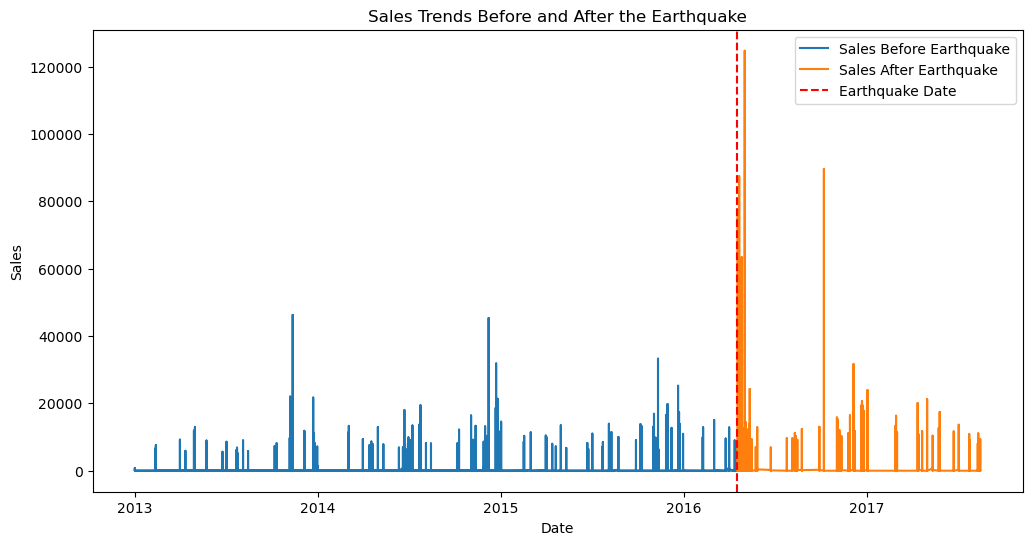

p_value: 5.925430444031771e-125
The earthquake had a significant impact on sales.


In [295]:
# A magnitude 7.8 earthquake struck Ecuador on April 16, 2016. 
# Question 9: Did the earthquake impact sales? 

# Define the earthquake date (April 16, 2016)
earthquake_date = pd.to_datetime('2016-04-16')

# Create time series for sales before and after the earthquake
sales_before_earthquake = merged_df[merged_df['date'] < earthquake_date]
sales_after_earthquake = merged_df[merged_df['date'] >= earthquake_date]

# Plot sales trends before and after the earthquake
plt.figure(figsize=(12, 6))
plt.plot(sales_before_earthquake['date'], sales_before_earthquake['sales'], label='Sales Before Earthquake')
plt.plot(sales_after_earthquake['date'], sales_after_earthquake['sales'], label='Sales After Earthquake')
plt.axvline(x=earthquake_date, color='red', linestyle='--', label='Earthquake Date')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.title('Sales Trends Before and After the Earthquake')
plt.legend()
plt.show()



# Check if the impact of the earthquake on sales is significant

import pandas as pd
import scipy.stats as stats

# Define the earthquake date (April 16, 2016)
earthquake_date = pd.to_datetime('2016-04-16')

# Create time series for sales before and after the earthquake
sales_before_earthquake = merged_df[merged_df['date'] < earthquake_date]['sales']
sales_after_earthquake = merged_df[merged_df['date'] >= earthquake_date]['sales']

# Perform two-sample t-test
t_statistic, p_value = stats.ttest_ind(sales_before_earthquake, sales_after_earthquake)

# Define significance level
alpha = 0.05

# Check if there was a significant impact on sales due to the earthquake
print ("p_value:", p_value)

if p_value < alpha:
    print("The earthquake had a significant impact on sales.")
else:
    print("There is no significant evidence of the earthquake impacting sales.")

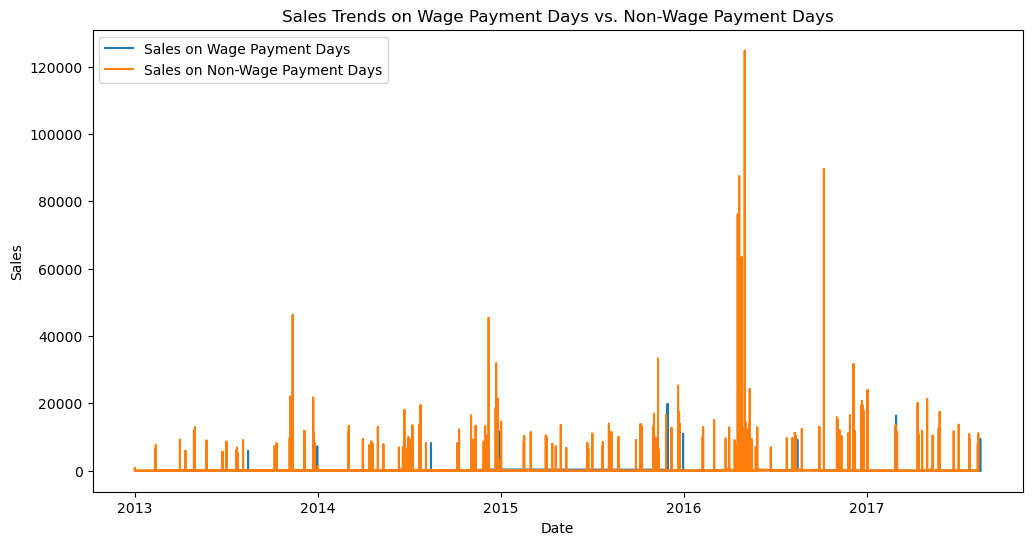

P-value: 0.6755650735289791
There is no significant difference in sales between wage payment days and non-wage payment days.


In [296]:
# Wages in the public sector are paid every two weeks on the 15th and on the last day of the month. 
# Question 10: Could Supermarket sales could be affected by this?

# Extract day of the month from the 'date' column
merged_df['day_of_month'] = merged_df['date'].dt.day

# Separate sales on wage payment days (15th and last day of the month)
sales_wage_payment_days = merged_df[(merged_df['day_of_month'] == 15) | (merged_df['day_of_month'] == merged_df['date'].dt.days_in_month)]

# Separate sales on non-wage payment days
sales_non_wage_payment_days = merged_df[(merged_df['day_of_month'] != 15) & (merged_df['day_of_month'] != merged_df['date'].dt.days_in_month)]

# Plot sales trends on wage payment days and non-wage payment days
plt.figure(figsize=(12, 6))
plt.plot(sales_wage_payment_days['date'], sales_wage_payment_days['sales'], label='Sales on Wage Payment Days')
plt.plot(sales_non_wage_payment_days['date'], sales_non_wage_payment_days['sales'], label='Sales on Non-Wage Payment Days')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.title('Sales Trends on Wage Payment Days vs. Non-Wage Payment Days')
plt.legend()
plt.show()


# Checking if there is a significant difference

# Extract day of the month from the 'date' column
merged_df['day_of_month'] = merged_df['date'].dt.day

# Separate sales on wage payment days (15th and last day of the month)
sales_wage_payment_days = merged_df[(merged_df['day_of_month'] == 15) | (merged_df['day_of_month'] == merged_df['date'].dt.days_in_month)]['sales']

# Separate sales on non-wage payment days
sales_non_wage_payment_days = merged_df[(merged_df['day_of_month'] != 15) & (merged_df['day_of_month'] != merged_df['date'].dt.days_in_month)]['sales']

# Perform two-sample t-test
t_statistic, p_value = stats.ttest_ind(sales_wage_payment_days, sales_non_wage_payment_days)

# Print the p-value
print("P-value:", p_value)

# Define significance level
alpha = 0.05

# Check if there is a significant difference in sales between wage payment days and non-wage payment days
if p_value < alpha:
    print("There is a significant difference in sales between wage payment days and non-wage payment days.")
else:
    print("There is no significant difference in sales between wage payment days and non-wage payment days.")

# Feature Engineering

## Dropping Unneccessary Columns in The Merged and Test Datasets

In [297]:
# Group and drop columns not needed for modelling

columns_to_drop = ['id', 'locale', 'locale_name', 'description', 'store_type', 'transferred', 'state']
merged_df_copy = merged_df_copy.drop(columns=columns_to_drop)

merged_df_copy.head()

,date,store_nbr,family,sales,onpromotion,city,cluster,transactions,holiday_type,dcoilwtico
0,2013-02-11,1.0,AUTOMOTIVE,0.0,0.0,Quito,13,396,Holiday,97.010002
1,2013-02-11,1.0,MAGAZINES,0.0,0.0,Quito,13,396,Holiday,97.010002
2,2013-02-11,1.0,"LIQUOR,WINE,BEER",21.0,0.0,Quito,13,396,Holiday,97.010002
3,2013-02-11,1.0,LINGERIE,0.0,0.0,Quito,13,396,Holiday,97.010002
4,2013-02-11,1.0,LAWN AND GARDEN,3.0,0.0,Quito,13,396,Holiday,97.010002


In [300]:
# Drop Unneccessary columns in the test dataset
test_df.drop('id', axis=1, inplace=True)
test_df.head()

,date,store_nbr,family,onpromotion
0,2017-08-16,1,AUTOMOTIVE,0
1,2017-08-16,1,BABY CARE,0
2,2017-08-16,1,BEAUTY,2
3,2017-08-16,1,BEVERAGES,20
4,2017-08-16,1,BOOKS,0


In [299]:
# Extracting Date Components
merged_df_copy['date'] = pd.to_datetime(merged_df_copy['date'])
merged_df_copy['year'] = merged_df_copy['date'].dt.year
merged_df_copy['month'] = merged_df_copy['date'].dt.month
merged_df_copy['day'] = merged_df_copy['date'].dt.day
merged_df_copy['dayofweek'] = merged_df_copy['date'].dt.weekday
merged_df_copy.head()

,date,store_nbr,family,sales,onpromotion,city,cluster,transactions,holiday_type,dcoilwtico,year,month,day,dayofweek
0,2013-02-11,1.0,AUTOMOTIVE,0.0,0.0,Quito,13,396,Holiday,97.010002,2013,2,11,0
1,2013-02-11,1.0,MAGAZINES,0.0,0.0,Quito,13,396,Holiday,97.010002,2013,2,11,0
2,2013-02-11,1.0,"LIQUOR,WINE,BEER",21.0,0.0,Quito,13,396,Holiday,97.010002,2013,2,11,0
3,2013-02-11,1.0,LINGERIE,0.0,0.0,Quito,13,396,Holiday,97.010002,2013,2,11,0
4,2013-02-11,1.0,LAWN AND GARDEN,3.0,0.0,Quito,13,396,Holiday,97.010002,2013,2,11,0


## Lag Features

In [304]:
# Number of lag features
num_lags = 7 # assuming a weekly seasonality

# Create lagged features for 'sales'
for i in range(1, num_lags + 1):
    merged_df_copy[f'sales_lag_{i}'] = merged_df_copy['sales'].shift(i)

# Drop rows with NaN values due to the shifting
merged_df_copy.dropna(subset=[f'sales_lag_{num_lags}'], inplace=True)

# Check the updated DataFrame
merged_df_copy.head()

,date,store_nbr,family,sales,onpromotion,city,cluster,transactions,holiday_type,dcoilwtico,...,dayofweek,sales_lag_1,sales_lag_2,sales_lag_3,sales_lag_4,sales_lag_5,sales_lag_6,sales_lag_7,rolling_mean,rolling_std
21,2013-02-11,1.0,BEVERAGES,172.0,0.0,Quito,13,396,Holiday,97.010002,...,0,0.0,96.248,0.000,152.000,151.000,26.321,46.000,85.367000,75.754868
22,2013-02-11,1.0,BEAUTY,0.0,0.0,Quito,13,396,Holiday,97.010002,...,0,172.0,0.000,96.248,0.000,152.000,151.000,26.321,81.606857,79.723401
23,2013-02-11,1.0,BABY CARE,0.0,0.0,Quito,13,396,Holiday,97.010002,...,0,0.0,172.000,0.000,96.248,0.000,152.000,151.000,60.035429,78.232462
24,2013-02-11,1.0,FROZEN FOODS,22.0,0.0,Quito,13,396,Holiday,97.010002,...,0,0.0,0.000,172.000,0.000,96.248,0.000,152.000,41.464000,67.449777
25,2013-02-11,1.0,PERSONAL CARE,23.0,0.0,Quito,13,396,Holiday,97.010002,...,0,22.0,0.000,0.000,172.000,0.000,96.248,0.000,44.749714,65.628905


## Rolling Mean and Standard Deviation

In [305]:
# Create rolling window statistics for 'sales'
window_size = 7

# 7-day rolling mean of 'sales'
merged_df_copy['rolling_mean'] = merged_df_copy['sales'].rolling(window=window_size).mean()

# 7-day rolling standard deviation of 'sales'
merged_df_copy['rolling_std'] = merged_df_copy['sales'].rolling(window=window_size).std()

# Check the updated DataFrame
merged_df_copy.head()

,date,store_nbr,family,sales,onpromotion,city,cluster,transactions,holiday_type,dcoilwtico,...,dayofweek,sales_lag_1,sales_lag_2,sales_lag_3,sales_lag_4,sales_lag_5,sales_lag_6,sales_lag_7,rolling_mean,rolling_std
21,2013-02-11,1.0,BEVERAGES,172.0,0.0,Quito,13,396,Holiday,97.010002,...,0,0.0,96.248,0.000,152.000,151.000,26.321,46.000,NaN,NaN
22,2013-02-11,1.0,BEAUTY,0.0,0.0,Quito,13,396,Holiday,97.010002,...,0,172.0,0.000,96.248,0.000,152.000,151.000,26.321,NaN,NaN
23,2013-02-11,1.0,BABY CARE,0.0,0.0,Quito,13,396,Holiday,97.010002,...,0,0.0,172.000,0.000,96.248,0.000,152.000,151.000,NaN,NaN
24,2013-02-11,1.0,FROZEN FOODS,22.0,0.0,Quito,13,396,Holiday,97.010002,...,0,0.0,0.000,172.000,0.000,96.248,0.000,152.000,NaN,NaN
25,2013-02-11,1.0,PERSONAL CARE,23.0,0.0,Quito,13,396,Holiday,97.010002,...,0,22.0,0.000,0.000,172.000,0.000,96.248,0.000,NaN,NaN


## Train-Test Split

In [306]:
# Define the cutoff date for train-test split
cutoff_date = pd.to_datetime('2016-08-01')

# Split the data into training and testing sets
train_df = merged_df_copy[merged_df_copy['date'] < cutoff_date]
test_df = merged_df_copy[merged_df_copy['date'] >= cutoff_date]

# Check the shapes of the training and testing sets
print("Training set shape:", train_df.shape)
print("Testing set shape:", test_df.shape)

Training set shape: (245136, 23)
Testing set shape: (76890, 23)


# Modelling

## Stationarity test

In [311]:
# Stationarity test
def adf_test(timeseries):
    result = adfuller(timeseries)
    print("ADF Statistic:", result[0])
    print("p-value:", result[1])
    print("Critical Values:")
    for key, value in result[4].items():
        print(f"\t{key}: {value}")
    if result[1] <= 0.05:
        print("The data is stationary.")
        return True
    else:
        print("The data is non-stationary.")
        return False

## Hyperparameter Tuning

In [313]:
import itertools

# Define a function to evaluate ARIMA model with given hyperparameters
def evaluate_arima_model(order, data):
    try:
        model = ARIMA(data, order=order)
        model_fit = model.fit()
        predictions = model_fit.forecast(len(data))
        rmsle = np.sqrt(mean_squared_log_error(data, predictions))
        return rmsle
    except:
        return None

# Define the range of values for p, d, and q
p_values = range(0, 3)  # The range is adjustable
d_values = range(0, 3)
q_values = range(0, 3)

# Generate all possible combinations of p, d, and q values
param_combinations = list(itertools.product(p_values, d_values, q_values))

# Initialize variables to store best results
best_rmsle = float('inf')
best_order = None

# Iterate through each combination and evaluate the model
for order in param_combinations:
    rmsle = evaluate_arima_model(order, sales)  
    if rmsle is not None and rmsle < best_rmsle:
        best_rmsle = rmsle
        best_order = order

# Print the best hyperparameters and RMSLE
print("Best Hyperparameters (p, d, q):", best_order)
print("Best RMSLE:", best_rmsle)

Best Hyperparameters (p, d, q): (1, 1, 0)
Best RMSLE: 2.9051392052147085


RMSE: 1499.9234786481613
MSE: 2249770.4418000015
MAE: 497.4884302509164
RMSLE: 2.96836086274234


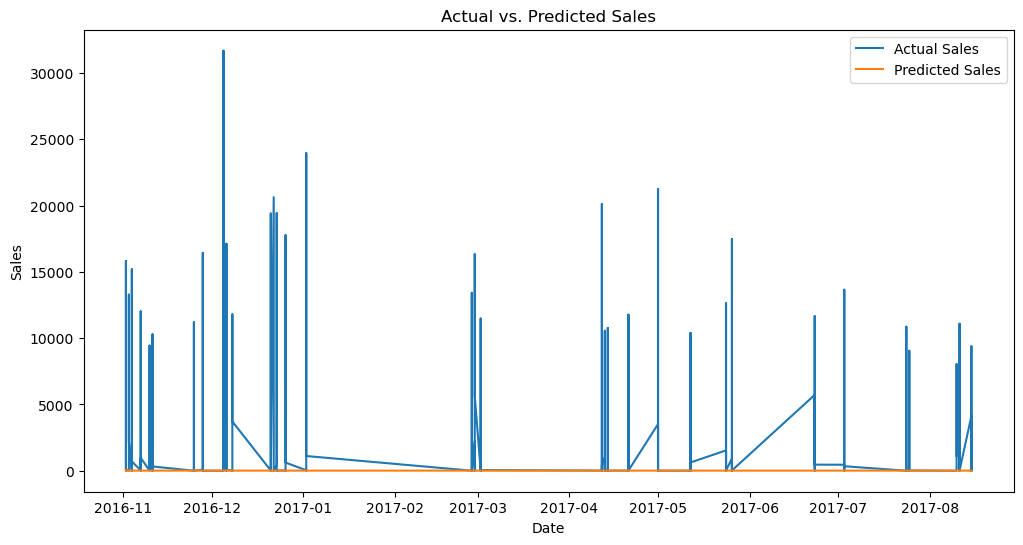

In [316]:
# Convert the 'date' column to datetime type
merged_df_copy['date'] = pd.to_datetime(merged_df_copy['date'])

# Sort the DataFrame based on the 'date' column in ascending order
merged_df_copy.sort_values('date', inplace=True)

# Split the data into training and testing sets (e.g., 80% train, 20% test)
train_size = int(len(merged_df_copy) * 0.8)
train_data = merged_df_copy[:train_size]
test_data = merged_df_copy[train_size:]

# Define the ARIMA hyperparameters (p, d, q)
p, d, q = 1, 1, 0

# Create and fit the ARIMA model
arima_model = ARIMA(train_data['sales'], order=(p, d, q))
arima_model_fit = arima_model.fit()

# Make predictions on the test set
start = len(train_data)
end = len(merged_df_copy) - 1
predictions = arima_model_fit.predict(start=start, end=end, dynamic=False)

# Calculate evaluation metrics
rmse = np.sqrt(mean_squared_error(test_data['sales'], predictions))
mse = mean_squared_error(test_data['sales'], predictions)
mae = mean_absolute_error(test_data['sales'], predictions)
rmsle = np.sqrt(np.mean(np.square(np.log(predictions + 1) - np.log(test_data['sales'] + 1))))

# Print evaluation metrics
print("RMSE:", rmse)
print("MSE:", mse)
print("MAE:", mae)
print("RMSLE:", rmsle)

# Visualize the actual sales and predicted sales
plt.figure(figsize=(12, 6))
plt.plot(test_data['date'], test_data['sales'], label='Actual Sales')
plt.plot(test_data['date'], predictions, label='Predicted Sales')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.title('Actual vs. Predicted Sales')
plt.legend()
plt.show()